In [2]:
import numpy as np
import pandas as pd
from spec_id import RT_spec,Gen_spec, Analyze_LH,Median_w_Error_cont,Oldest_galaxy
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13, z_at_value
from astropy.table import Table
from astropy.io import fits
import astropy
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [9]:
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

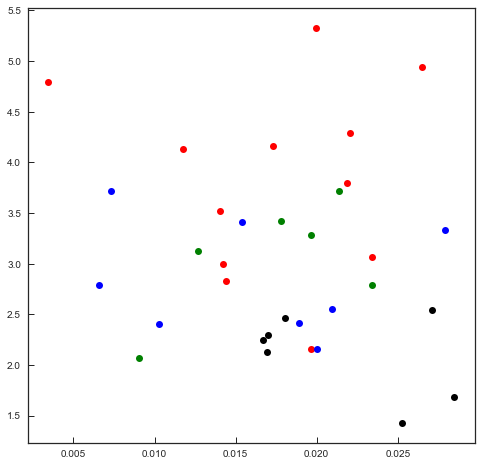

In [16]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(lzDB['Zx_dt'],lzDB['tx_dt'],'ro')
plt.plot(mzDB['Zx_dt'],mzDB['tx_dt'],'bo')
plt.plot(hzDB['Zx_dt'],hzDB['tx_dt'],'go')
plt.plot(uhzDB['Zx_dt'],uhzDB['tx_dt'],'ko')